In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import datetime
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings("ignore")
import pandasql as ps
import calendar

In [21]:
# Import data
sales=pd.read_csv('/Users/apple/Desktop/python side project/Namesake/sales_data.csv')
items=pd.read_csv('/Users/apple/Desktop/python side project/Namesake/items_bought.csv')

# Rename column name
sales.rename(columns={'customer_id_random':'customer_id','order_id_random':'order_id','net_sales_scaled':'net_sales'},inplace=True)
items.rename(columns={'customer_id_random':'customer_id','net_sales_scaled':'net_sales'},inplace=True)

# Exploratory Data Analysis

In [4]:
# Show sales data
sales.head()

,datetime,customer_id,order_id,net_sales
0,2023-07-22,4794497084,4472634531,8.79
1,2023-07-23,2163752822,6055468369,13.39
2,2023-08-05,2163752822,7486174375,14.50
3,2023-08-14,8872646774,6199640363,9.96
4,2023-08-06,605622184,1616493641,11.50


In [22]:
# Show items data
items.head()

,customer_id,product_type,net_sales
0,808706493,23,3.62
1,2762797853,22,3.75
2,2762797853,12,3.40
3,2762797853,16,1.78
4,2762797853,11,5.22


**Sales Analysis for each Product Type**

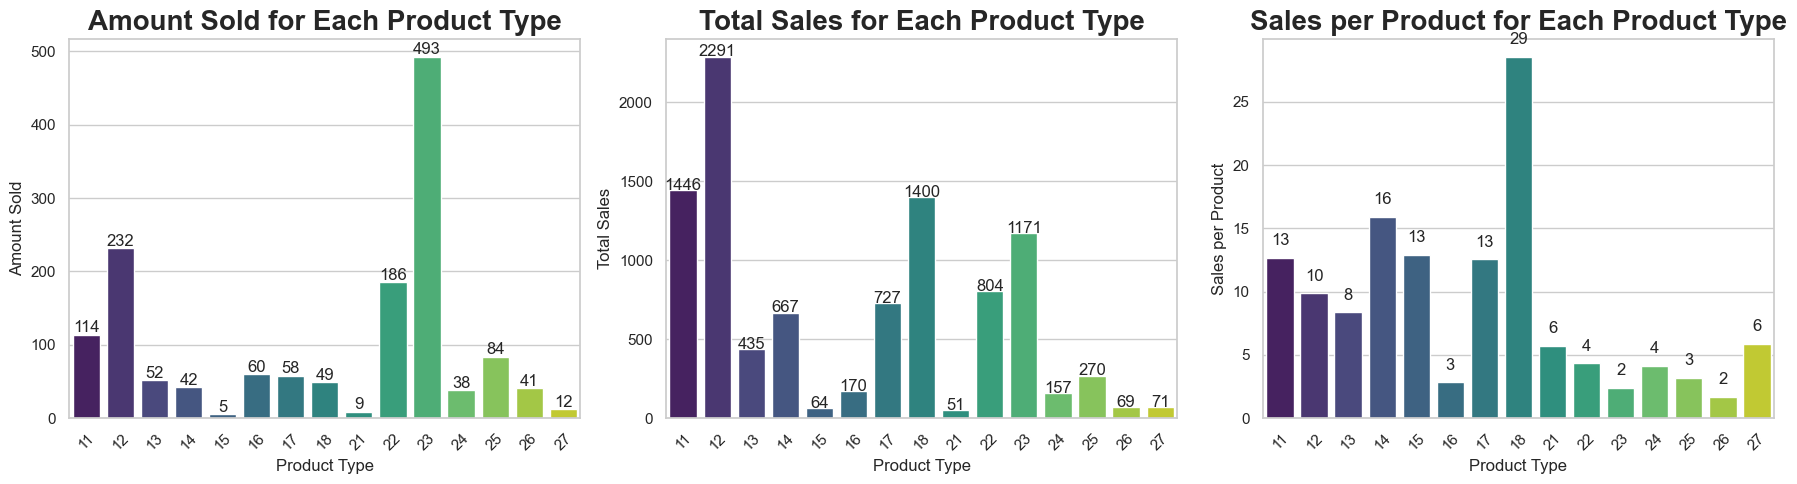

In [23]:
# Sales analysis for each product_type
# Create a new dataframe that contains the amount sold and total sales of each product type
query=''' 
SELECT
    product_type,
    COUNT(*) AS amount_sold,
    SUM(net_sales) AS total_sales
FROM
    items
GROUP BY
    product_type
'''
product_type_sales=ps.sqldf(query,locals())

# Barplot for each product type's amount sold, total sales, sales per product
plt.figure(figsize=(18, 5))

# Plot 1: Amount Sold for Each Product Type
plt.subplot(131)
s1=sns.barplot(x='product_type', y='amount_sold', data=product_type_sales, palette='viridis')
for p in s1.patches:
    s1.text(
        p.get_x()+p.get_width()/2,p.get_height()+3,f'{p.get_height():.0f}',ha='center'
    )
plt.title('Amount Sold for Each Product Type', fontsize=20, weight='bold')
plt.xlabel('Product Type')
plt.ylabel('Amount Sold')
plt.xticks(rotation=45)

# Plot 2: Total Sales for Each Product Type
plt.subplot(132)
s2=sns.barplot(x='product_type', y='total_sales', data=product_type_sales, palette='viridis')
for p in s2.patches:
    s2.text(
        p.get_x()+p.get_width()/2,p.get_height()+3,f'{p.get_height():.0f}',ha='center'
    )
plt.title('Total Sales for Each Product Type', fontsize=20, weight='bold')
plt.xlabel('Product Type')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)

# Plot 3: Sales per Product for Each Product Type
product_type_sales['sales_per_product'] = product_type_sales['total_sales'] / product_type_sales['amount_sold']

plt.subplot(133)
s3=sns.barplot(x='product_type', y='sales_per_product', data=product_type_sales, palette='viridis')
for p in s3.patches:
    s3.text(
        p.get_x()+p.get_width()/2,p.get_height()+1,f'{p.get_height():.0f}',ha='center'
    )
plt.title('Sales per Product for Each Product Type', fontsize=20, weight='bold')
plt.xlabel('Product Type')
plt.ylabel('Sales per Product')
plt.xticks(rotation=45)

# Show all plots
plt.tight_layout()

>This image consists of three bar charts analyzing product sales:  
>1. Amount Sold for Each Product Type: Displays the number of units sold for each product category. Product type 23 has the highest quantity sold (493 units), followed by 12 (232 units). 
>2. Total Sales for Each Product Type: Shows total revenue per product type. Product 12 generates the highest revenue (2,291), followed by 11 (1,446) and 23 (1,171). 
>3. Sales per Product: Represents the average revenue per unit sold. Product 18 has the highest sales per unit (29), followed by 16 (16) and 11 (13).

**Monthly Net Sales Analysis**

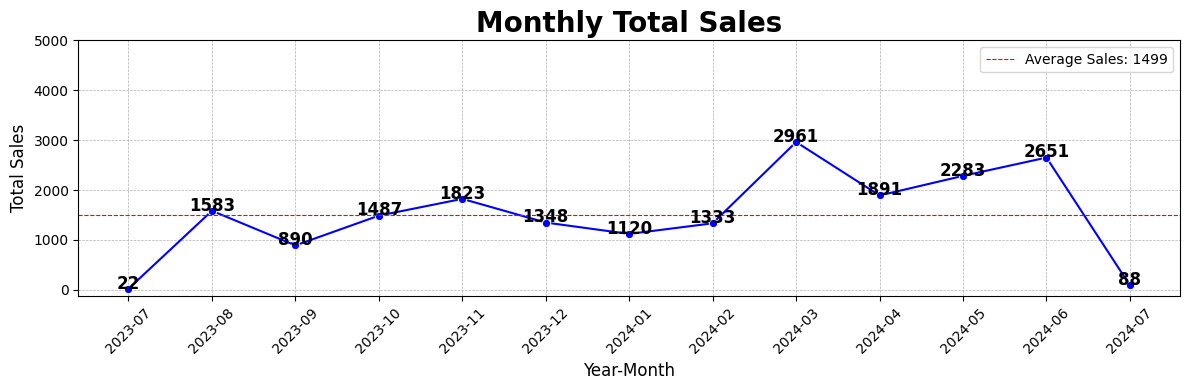

In [6]:
# Monthly Net Sales Analysis
sales['datetime']=pd.to_datetime(sales['datetime'])
query = """
    SELECT 
        strftime('%Y-%m', datetime) AS year_month,  -- Extract year and month (YYYY-MM)
        SUM(net_sales) AS total_sales
    FROM 
        sales
    GROUP BY 
        year_month
    ORDER BY 
        year_month
"""

# Execute the SQL query using pandasql
monthly_sales = ps.sqldf(query, locals())

# Convert `year_month` to string for plotting
monthly_sales['year_month'] = monthly_sales['year_month'].astype(str)

# Plot lineplot
plt.figure(figsize=(12, 4))  
sns.lineplot(x='year_month', y='total_sales', data=monthly_sales, marker='o', color='b')
for x, y in zip(monthly_sales['year_month'], monthly_sales['total_sales']):
    plt.text(x, y + 3, f'{int(y)}', ha='center', fontsize=12, color='black', weight='bold')
plt.title('Monthly Total Sales', fontsize=20, weight='bold')
plt.xlabel('Year-Month', fontsize=12)
plt.ylabel('Total Sales', fontsize=12)
plt.xticks(rotation=45)
plt.yticks(range(0, 5200, 1000))
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.axhline(monthly_sales['total_sales'].mean(), color='red', linestyle='--', linewidth=0.8, label=f'Average Sales: {monthly_sales['total_sales'].mean():.0f}')
plt.legend()

The graph shows monthly total sales from July 2023 to July 2024, with significant fluctuations. Peaks occurred in March 2024 (2,961 units) and June 2024 (2,651 units). Several months fell below the average of 1,499 units, indicating possible seasonal trends.

**Weekly Order Count Analysis**

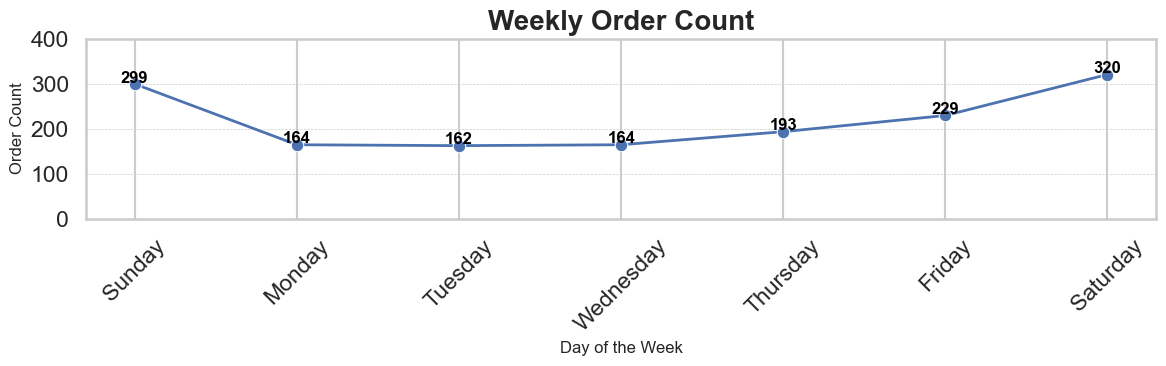

In [7]:
# Weekly Order Count Analysis
query = """
    SELECT 
        strftime('%w', datetime) AS day_of_week,  
        COUNT(DISTINCT order_id) AS order_count
    FROM 
        sales
    GROUP BY 
        day_of_week
    ORDER BY 
        day_of_week
"""

# Execute the SQL query using pandasql
weekly_sales = ps.sqldf(query, locals())

# Map the numerical weekday to the day names
weekly_sales['day_of_week'] = weekly_sales['day_of_week'].astype(int)
weekly_sales['day_of_week'] = weekly_sales['day_of_week'].map({
    0: 'Sunday',
    1: 'Monday', 
    2: 'Tuesday', 
    3: 'Wednesday', 
    4: 'Thursday', 
    5: 'Friday', 
    6: 'Saturday'
})

# Line plot for Weekly Net Sales
plt.figure(figsize=(12, 4))
sns.set(style="whitegrid", context="talk")
# Create lineplot of weekly net sales
s = sns.lineplot(x='day_of_week', y='order_count', data=weekly_sales, marker='o', palette="viridis", linewidth=2)

# Add data labels at each point
for x, y in zip(weekly_sales['day_of_week'], weekly_sales['order_count']):
    plt.text(x, y + 3, f'{int(y)}', ha='center', fontsize=12, color='black', weight='bold')
plt.title('Weekly Order Count', fontsize=20, weight='bold')
plt.xlabel('Day of the Week', fontsize=12)
plt.ylabel('Order Count', fontsize=12)
plt.ylim(0,400)
plt.xticks(rotation=45)
plt.yticks(range(0, 410, 100))
plt.grid(True, linestyle='--', linewidth=0.5, axis='y')
plt.tight_layout()

The graph shows the weekly order count, with the lowest orders on Tuesday (162) and the highest on Saturday (320). Orders decline from Sunday (299) to Tuesday and then gradually increase throughout the week. This pattern suggests higher customer activity on weekends.

**Net Sales Per Order Analysis**

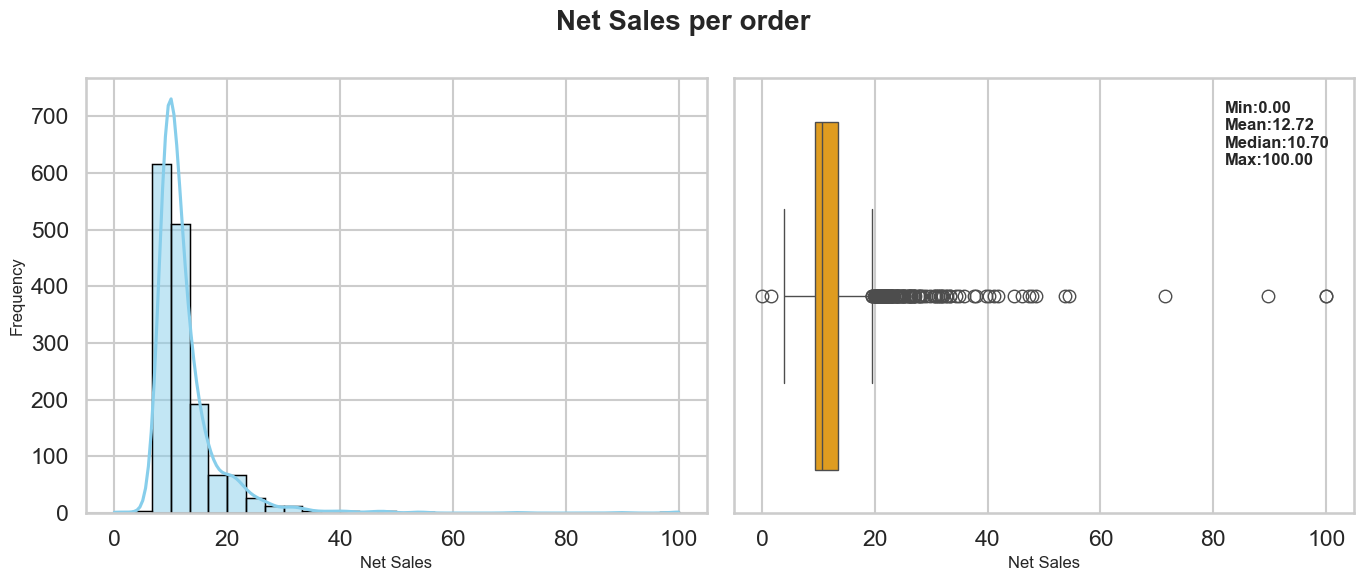

In [ ]:
# Net Sales Per Order Analysis
plt.figure(figsize=(14, 6))
plt.suptitle('Net Sales per order', fontsize=20, weight='bold')
# Subplot 1: Histogram with KDE 
plt.subplot(1, 2, 1)
sns.histplot(sales['net_sales'], bins=30, kde=True, color='skyblue', edgecolor='black')
plt.xlabel('Net Sales', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# Subplot 2: Box Plot with Min, Mean, and Max as Legend
plt.subplot(1, 2, 2)
sns.boxplot(x=sales['net_sales'], color='orange')
plt.xlabel('Net Sales', fontsize=12)

# Calculate Min, Mean, and Max values
min_value = sales['net_sales'].min()
mean_value = sales['net_sales'].mean()
max_value = sales['net_sales'].max()
median_value=sales['net_sales'].quantile()

# Add Min, Mean, and Max values
plt.text(82,-0.3,f'Min:{min_value:.2f}\nMean:{mean_value:.2f}\nMedian:{median_value:.2f}\nMax:{max_value:.2f}',fontsize=12,weight='bold')

plt.tight_layout()

The distribution of net sales per order is highly skewed towards lower values. The median is 10.70, and the mean is slightly higher at 12.72. The boxplot confirms this with several distant outliers, while the majority of orders are tightly clustered near the lower end.

**RFM analysis**  
We can use R(recency) F(frequency) M(monetary) to analyze the behaviors of each customer

In [9]:
# create a RFM data 
query = """
SELECT
    customer_id,
    JULIANDAY('2024-07-01') - JULIANDAY(MAX(datetime)) AS recency,
    COUNT(DISTINCT order_id) AS frequency,
    SUM(net_sales) AS monetary
FROM
    sales
GROUP BY
    customer_id
ORDER BY
    monetary DESC
"""

# Execute the SQL query
RFM = ps.sqldf(query, locals())

# Drop values that will influence analysis
RFM=RFM[RFM['monetary']<300] # these customers are Purchasing agent, their purchase habits will be different from other customers

RFM[['recency','frequency','monetary']].describe()

,recency,frequency,monetary
count,996.000000,996.000000,996.000000
mean,138.330321,1.466867,18.733675
std,100.516687,1.421976,23.592813
min,0.000000,1.000000,6.520000
25%,50.000000,1.000000,9.470000
50%,114.000000,1.000000,11.675000
75%,225.000000,1.000000,19.340000
max,345.000000,25.000000,295.360000


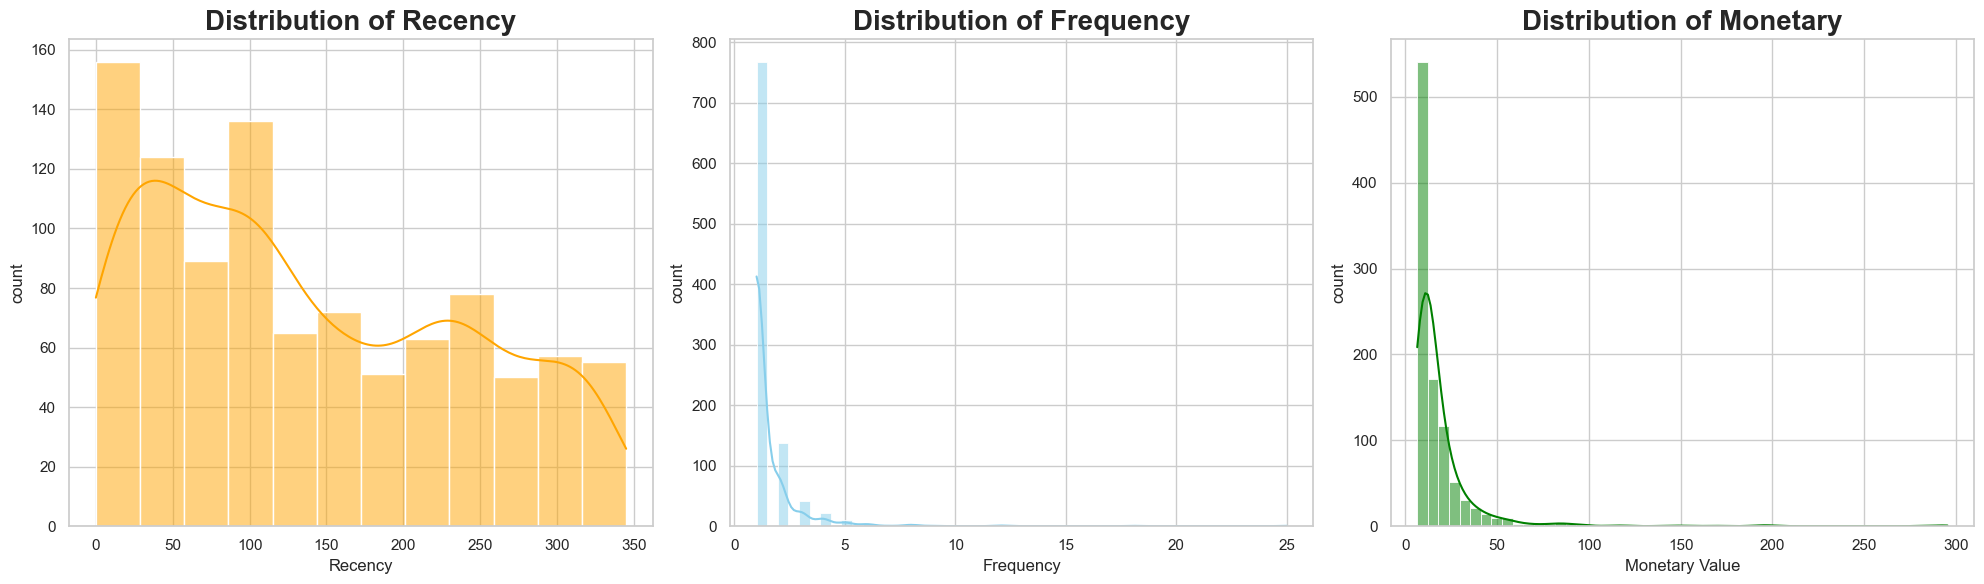

In [10]:
# Plot histplot for RFM data
plt.figure(figsize=(20, 6))  
sns.set(style="whitegrid") 

# Subplot 1 - Recency
plt.subplot(131)
sns.histplot(RFM['recency'], bins=12, color="orange", kde=True)
plt.title('Distribution of Recency', fontsize=20,weight='bold')
plt.xlabel('Recency', fontsize=12)
plt.ylabel('count', fontsize=12)
plt.grid(True)

# Subplot 2 - Frequency
plt.subplot(132)
sns.histplot(RFM['frequency'], bins=50, color="skyblue", kde=True)
plt.title('Distribution of Frequency', fontsize=20,weight='bold')
plt.xlabel('Frequency', fontsize=12)
plt.ylabel('count', fontsize=12)
plt.grid(True)

# Subplot 3 - Monetary
plt.subplot(133)
sns.histplot(RFM['monetary'], bins=50, color="green", kde=True)
plt.title('Distribution of Monetary', fontsize=20,weight='bold')
plt.xlabel('Monetary Value', fontsize=12)
plt.ylabel('count', fontsize=12)
plt.grid(True)

plt.tight_layout()

We can see that
Recency Graph: Most customers have recent transactions (low values), with a right-skewed distribution.
Frequency Graph: The majority of customers have very low transaction frequency, with a steep drop-off as frequency increases. 
Monetary Graph: Most customers have low spending amounts, with a few high-value customers contributing significantly.

**Frequency Analysis**

In [17]:
round(RFM[RFM['frequency']==1].shape[0]/RFM['frequency'].shape[0],2)

0.77

We see that there is 77% of customers that is a one time customer, so I decided to develop strategies to enhance customer loyalty, including VIP program, email campaigns, and free shipping policy

#VIP program  
create two tiers of VIP based on total amount spent last year and amount spent on single order

In [24]:
# Find the 50th percentile and 90th percentile of total sales by each customer
percentile_50 = round(RFM['monetary'].quantile(0.50),2)
percentile_90 = round(RFM['monetary'].quantile(0.90),2)
print(f"50th Percentile of Monetary: {percentile_50}")
print(f"90th Percentile of Monetary: {percentile_90}")

# Find the 90th percentile of sales by each order
percentile_90 = round(sales['net_sales'].quantile(0.90),2)
print(f"90th Percentile of net_sales_per_order: {percentile_90}")

50th Percentile of Monetary: 11.68
90th Percentile of Monetary: 32.02
90th Percentile of net_sales_per_order: 19.13


**tier1 customer: total spending last year exceeded 11.68**  
**tier2 customer: total spending last year exceeded 32.02 or single transaction amount exceeded 19.13 last year**

In [26]:
# tier1 customer: total spending last year exceeded 11.68
# tier2 customer: total spending last year exceeded 32.02 or single transaction amount exceeded 19.13 last year
query=''' 
SELECT 
    s.customer_id,
    CASE 
        WHEN MAX(r.monetary)>=11.68 and MAX(r.monetary)<32.02 THEN "TIER1"
        WHEN MAX(r.monetary)>=32.02 or MAX(s.net_sales)>=19.13 THEN "TIER2"
        ELSE "NULL"
    END as tier
FROM sales s INNER JOIN RFM r on s.customer_id=r.customer_id
GROUP BY s.customer_id
'''
customer_tier=ps.sqldf(query,locals())
customer_tier['tier'].value_counts()

tier
NULL     498
TIER1    398
TIER2    100
Name: count, dtype: int64

**We see that approximately 10% of our customer will become out VVIP, and approximately 40% will become our VIP**

#Email Campaigns
Applied K-means clustering to segment customers into three groups based on purchase preferences and total spend, then developed tailored marketing strategies for each segment to boost engagement.

**Create customer product preference dataframe**  
Compute the product prefernce(Using customers' past purchases of different product types, calculate a weighted average, a preference score closer to 10 indicates a stronger tendency toward fashion styles, while a score closer to 1 indicates a preference for regular styles.) and total_sales for each customer

In [28]:
# create cpp(customer product preference) dataframe
query=''' 
SELECT
    customer_id,
    AVG(CASE 
        WHEN CAST(SUBSTR(product_type, 1, 1) AS INTEGER) = 1 THEN 10
        WHEN CAST(SUBSTR(product_type, 1, 1) AS INTEGER) = 2 THEN 1
        ELSE 0
    END) AS product_preference,
    SUM(net_sales) AS total_sales
FROM
    items
GROUP BY
    customer_id
ORDER BY total_sales DESC
'''
cpp=ps.sqldf(query,locals())

# Drop total_sales>300, these are purchasing agent, their purchase habits will be different from other customers
cpp=cpp[cpp['total_sales']<300]
cpp

,customer_id,product_preference,total_sales
3,1866092896,10.000000,210.77
4,5281799789,6.785714,153.02
5,3182081116,5.153846,127.49
6,3079348898,8.105263,107.99
7,7449397431,10.000000,107.15
...,...,...,...
673,3030191785,1.000000,1.04
674,1936801602,1.000000,1.04
675,600263589,1.000000,1.04
676,154429,1.000000,1.04


In [ ]:
# Create customer segmentation based on product_prefernce and total_sales
# See if the data is normally distributed
print("Skewness before transformation:")
print(cpp[['product_preference','total_sales']].skew()) # Skewness > 1 or < -1 indicates high skew, then we will have to log these columns
# we see that total_sales is highly skewed, so we'll have to log this data